Network Analysis of Vaccination Strategies  
Copyright (C) 2020 by The RAND Corporation  
See LICENSE.txt and README.txt for information on usage and licensing

# Contact Network Analysis

The purpose of this notebook is to analyze the contact networks.

In [1]:
import os, collections, random, zipfile
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import itertools

from utils import *

import matplotlib.pyplot as plt
import matplotlib.style as style 
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

plt.style.use('figures/theme_bw.mplstyle')
%matplotlib inline

fontsize = 16
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
fmt = mticker.FuncFormatter(g)
#pd.options.display.float_format = "{:,.3f}".format

colormap = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
## create a figures directory if it does not already exist
if not os.path.exists('figures'):
    os.mkdir('figures')       

## Approach A: Separate contact network for before and during social distancing

**N.B.** These graphs include the edge weights.

In [4]:
#G_pre = nx.read_gpickle("data/G_pre.gpickle")
#G_post = nx.read_gpickle("data/G_post.gpickle")

G_pre = nx.read_weighted_edgelist("data/G_pre.adjlist", nodetype=float)
G_post = nx.read_weighted_edgelist("data/G_post.adjlist", nodetype=float)

In [5]:
#nx.write_edgelist(G_pre, 'data/G_pre.csv', delimiter=',', data=['weight'])
#nx.write_edgelist(G_post, 'data/G_post.csv', delimiter=',', data=['weight'])

In [6]:
print_network_stats(G_pre)

number of edges 1538092 
number of nodes 214393 
number of edges/nodes 7.17 
density 6.69e-05
fraction of nodes in largest component: 1.000


In [7]:
print_network_stats(G_post)

number of edges 351512 
number of nodes 130910 
number of edges/nodes 2.69 
density 4.10e-05
fraction of nodes in largest component: 1.000


Visualize the neighborhood of a random node, both before and during social distancing.

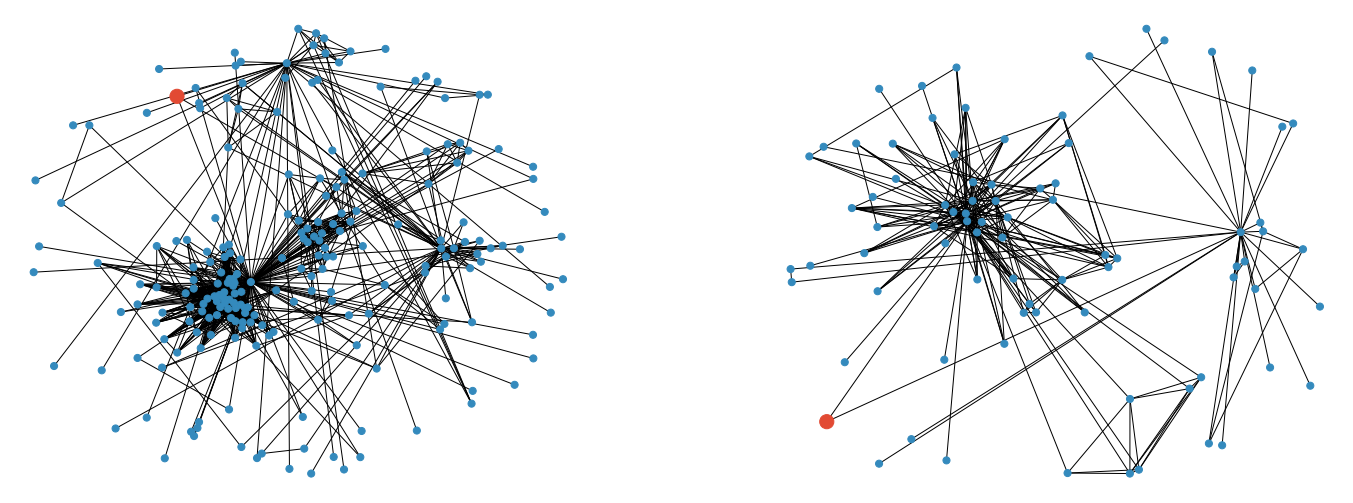

In [8]:
## pick a random node in both graphs
np.random.seed(123)

## pick a root, if the pre subgraph is too large, pick another root
while True:
    root = np.random.choice(list(set(G_post.nodes()).intersection(G_pre.nodes())))
    subgraph_pre = neighbor_graph(G_pre, root)
    subgraph_post = neighbor_graph(G_post, root)
    if len(subgraph_pre.nodes()) < 300:
        break
        
fig, axarr = plt.subplots(1, 2, figsize=(2*12, 9))
fig.subplots_adjust(wspace=0.3)

node_color = []
node_size = []
for node in subgraph_pre.nodes():
    if node == root:
        node_color.append(colormap[0])
        node_size.append(200)
    else:
        node_color.append(colormap[1])
        node_size.append(50)
nx.draw(subgraph_pre, node_color=node_color, node_size=node_size, width=1, ax=axarr[0])

node_color = []
node_size = []
for node in subgraph_post.nodes():
    if node == root:
        node_color.append(colormap[0])
        node_size.append(200)
    else:
        node_color.append(colormap[1])
        node_size.append(50)
nx.draw(subgraph_post, node_color=node_color, node_size=node_size, width=1, ax=axarr[1])

#plt.savefig("figures/graph_pre_and_post.pdf", bbox_inches='tight')
plt.show()        

Compare the degree distribution for pre and during social distancing.

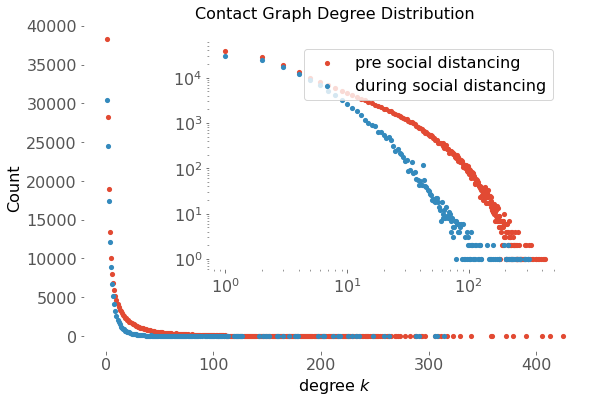

In [9]:
fig, ax = plt.subplots(figsize=(9,6))
ss = 10

## main plot
degree_dist_pre = degree_dist_calculator(G_pre)
ax.scatter(degree_dist_pre[0], degree_dist_pre[1], alpha=1, linewidth=2, s=ss, marker='o')

degree_dist_post = degree_dist_calculator(G_post)
ax.scatter(degree_dist_post[0], degree_dist_post[1], alpha=1, linewidth=2, s=ss, marker='o')

## inset
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.25,0.25,0.7,0.7])
ax2.set_axes_locator(ip)
ax2.scatter(degree_dist_pre[0], degree_dist_pre[1], \
            alpha=1, linewidth=2, s=ss, marker='o', label='pre social distancing')
ax2.scatter(degree_dist_post[0], degree_dist_post[1], \
            alpha=1, linewidth=2, s=ss, marker='o', label='during social distancing')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()

ax.set_ylabel("Count")
ax.set_xlabel(r"degree $k$")
ax.set_title('Contact Graph Degree Distribution')

ax.grid(False)
ax2.grid(False)

#plt.savefig("figures/degree_dist.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Plot just the inset (i.e. log-log scale):

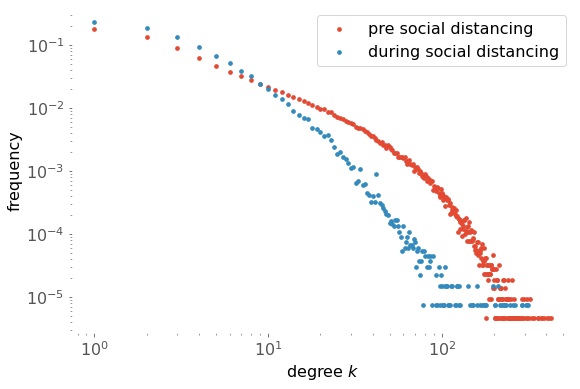

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
ax.grid(False)
lw = 3

## all degrees, log-log sclae
degree_dist_pre = degree_dist_calculator(G_pre)
ax.scatter(degree_dist_pre[0], degree_dist_pre[1]/degree_dist_pre[1].sum(), linewidth=lw, s=3, label='pre social distancing')

degree_dist_post = degree_dist_calculator(G_post)
ax.scatter(degree_dist_post[0], degree_dist_post[1]/degree_dist_post[1].sum(), linewidth=lw, s=3, label='during social distancing')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[1].set_xlim([0,20])
ax.legend()
ax.set_ylabel("frequency")
ax.set_xlabel(r"degree $k$")
#ax.set_title('Contact Network Degree Distribution')

plt.savefig("figures/degree_dist.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Also plot the distribution on a log-linear scale:

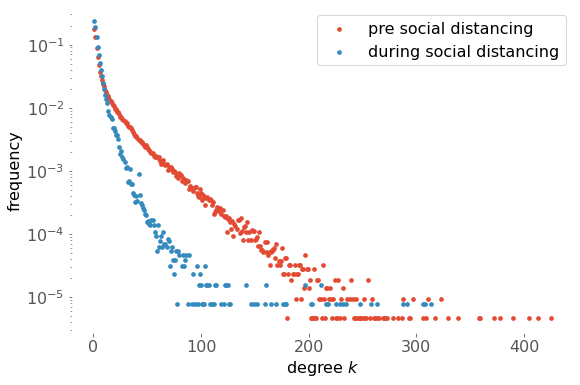

In [11]:
fig, ax = plt.subplots(figsize=(9,6))
ax.grid(False)
lw = 3

## all degrees, log-log sclae
degree_dist_pre = degree_dist_calculator(G_pre)
ax.scatter(degree_dist_pre[0], degree_dist_pre[1]/degree_dist_pre[1].sum(), linewidth=lw, s=3, label='pre social distancing')

degree_dist_post = degree_dist_calculator(G_post)
ax.scatter(degree_dist_post[0], degree_dist_post[1]/degree_dist_post[1].sum(), linewidth=lw, s=3, label='during social distancing')

#ax.set_xscale('log')
ax.set_yscale('log')
#ax[1].set_xlim([0,20])
ax.legend()
ax.set_ylabel("frequency")
ax.set_xlabel(r"degree $k$")
#ax.set_title('Contact Network Degree Distribution')

#plt.savefig("figures/degree_dist_loglinear.png", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Compute the distribution of the node strength $s$

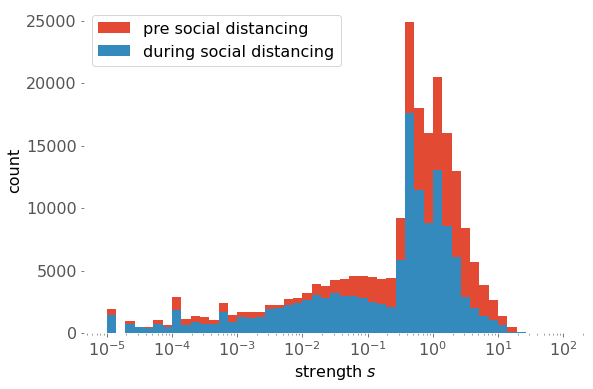

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
ax.grid(False)

bins = np.logspace(np.log10(1e-5),np.log10(1e2), 50)    
plt.hist(np.asarray(list(G_pre.degree(weight='weight')))[:,1], label='pre social distancing', bins=bins)#, density=True)
plt.hist(np.asarray(list(G_post.degree(weight='weight')))[:,1], label='during social distancing', bins=bins)#, density=True)
plt.xscale('log')
plt.legend()
ax.set_ylabel("count")
ax.set_xlabel(r"strength $s$")
#ax.set_title('Contact Network Degree Distribution')
plt.savefig("figures/strength_dist.pdf", bbox_inches='tight', transparent = True) #, pad_inches = 0
plt.show()

In [13]:
print(np.mean(np.asarray(list(dict(G_pre.degree).values())) <= 10))
print(np.mean(np.asarray(list(dict(G_post.degree).values())) <= 10))

0.6511266692475967
0.8786952868382858


In case the log-log scale obscures the behavior for low-degrees, here's a side-by-side plot with a linear and a log-log scale:

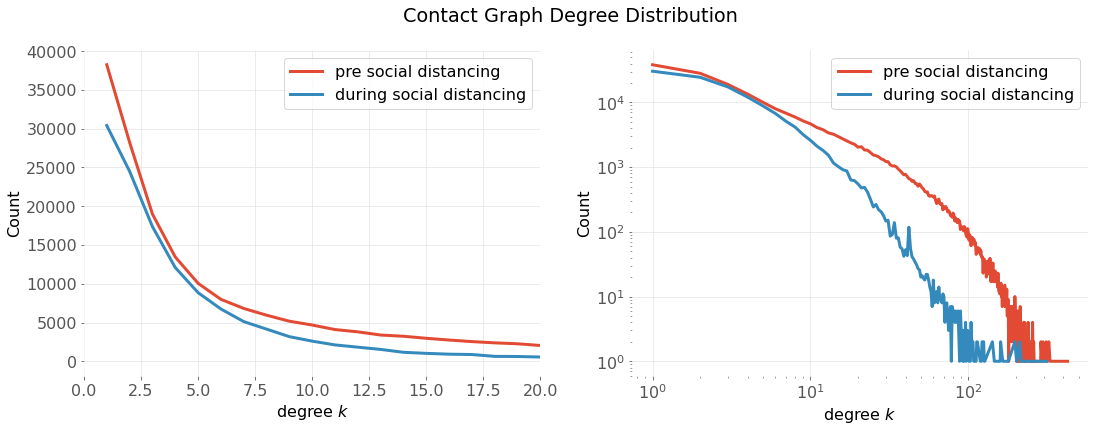

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(2*9,6))
lw = 3

## small degree, linear scale
degree_dist_pre = degree_dist_calculator(G_pre)
ax[0].plot(degree_dist_pre[0], degree_dist_pre[1], linewidth=lw, label='pre social distancing')

degree_dist_post = degree_dist_calculator(G_post)
ax[0].plot(degree_dist_post[0], degree_dist_post[1], linewidth=lw, label='during social distancing')

#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
ax[0].set_xlim([0,20])
ax[0].legend()
ax[0].set_ylabel("Count")
ax[0].set_xlabel(r"degree $k$")
#ax[0].set_title('Contact Graph Degree Distribution')

## all degrees, log-log sclae
degree_dist_pre = degree_dist_calculator(G_pre)
ax[1].plot(degree_dist_pre[0], degree_dist_pre[1], linewidth=lw, label='pre social distancing')

degree_dist_post = degree_dist_calculator(G_post)
ax[1].plot(degree_dist_post[0], degree_dist_post[1], linewidth=lw, label='during social distancing')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].set_xlim([0,20])
ax[1].legend()
ax[1].set_ylabel("Count")
ax[1].set_xlabel(r"degree $k$")
#ax[1].set_title('Contact Graph Degree Distribution')

plt.suptitle('Contact Graph Degree Distribution')

#plt.savefig("figures/degree_dist.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Make a rank-size plot:

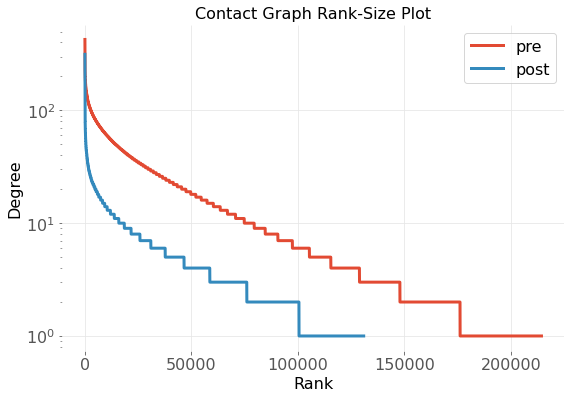

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
lw = 3

ax.plot(np.arange(G_pre.number_of_nodes()), -np.sort(-np.asarray(list(nx.degree(G_pre)))[:,1]), linewidth=lw, label='pre')
ax.plot(np.arange(G_post.number_of_nodes()), -np.sort(-np.asarray(list(nx.degree(G_post)))[:,1]), linewidth=lw, label='post')

#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Degree")
ax.set_xlabel(r"Rank")
ax.set_title('Contact Graph Rank-Size Plot')
ax.legend()
#plt.savefig("figures/degree_rank_loglinear.png", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

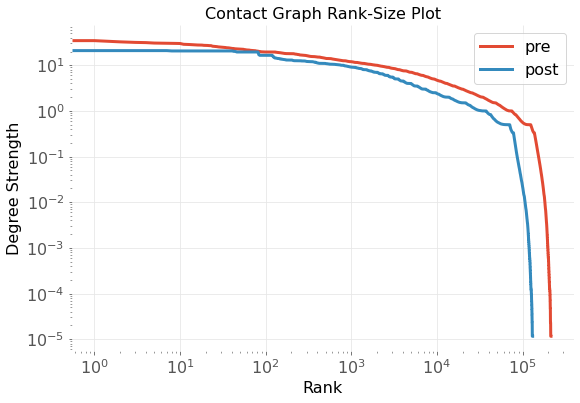

In [16]:
fig, ax = plt.subplots(figsize=(9,6))
lw = 3

ax.loglog(np.arange(G_pre.number_of_nodes()), -np.sort(-np.asarray(list(nx.degree(G_pre, weight='weight')))[:,1]), linewidth=lw, label='pre')
ax.loglog(np.arange(G_post.number_of_nodes()), -np.sort(-np.asarray(list(nx.degree(G_post, weight='weight')))[:,1]), linewidth=lw, label='post')

ax.set_ylabel("Degree Strength")
ax.set_xlabel(r"Rank")
ax.set_title('Contact Graph Rank-Size Plot')
ax.legend()
plt.show()

### power-law fits

To what extent are the tails of these networks scale-free? I'll use the package [powerlaw](https://pythonhosted.org/powerlaw/). First, let's define some helper functions.

In [17]:
def fraction_of_nodes_above_k(socialdist, xmin):
    '''return the fraction of nodes with degree >= xmin'''
    if socialdist == 'pre':
        return len([k for k in degree_sequence_pre if k >= xmin])/len(degree_sequence_pre)
    else:
        return len([k for k in degree_sequence_post if k >= xmin])/len(degree_sequence_post)
    
    
def pairwise_comparision(fit, dist1, dist2):
    '''
    A helper function for doing a pairwise fit comparison.
    
    The `distribution_compare` function returns
    R : float, Loglikelihood ratio of the two distributions’ fit to the data. If greater than 0, the first distribution is preferred. If less than 0, the second distribution is preferred.
    p : float, Significance of R
    '''
    
    R, p = fit.distribution_compare(dist1, dist2)
    if R > 0:
        print('dist1 = %s is favored over dist2 = %s, with R = %.2f, p = %.4e\n' %(dist1, dist2, R, p))
    else:
        print('dist2 = %s is favored over dist1 = %s, with R = %.2f, p = %.4e\n' %(dist2, dist1, R, p))
        
distributions = ['power_law', 'lognormal_positive', 'exponential']#, 'stretched_exponential']

**G_pre, xmin fit**: Results in very large xmin value, so only the tip of the tail is being fit.

In [18]:
degree_sequence_pre = np.asarray(sorted([d for n, d in G_pre.degree()], reverse=False))
powerlawfit_pre = powerlaw.Fit(degree_sequence_pre, discrete=True)

print('alpha = %.2f' %powerlawfit_pre.power_law.alpha)
print('xmin = %.2f' %powerlawfit_pre.power_law.xmin)
print('fraction_of_nodes_above_xmin: %.4f'% fraction_of_nodes_above_k('pre', powerlawfit_pre.power_law.xmin))

Calculating best minimal value for power law fit
/home/gavin/anaconda3/envs/eon/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/gavin/anaconda3/envs/eon/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


alpha = 5.94
xmin = 140.00
fraction_of_nodes_above_xmin: 0.0039


**G_pre, xmin specified**: Set xmin to be the median degree.

In [19]:
degree_sequence_pre = np.asarray(sorted([d for n, d in G_pre.degree()], reverse=False))
powerlawfit_pre = powerlaw.Fit(degree_sequence_pre, discrete=True, xmin=np.median(degree_sequence_pre))

print('alpha = %.2f' %powerlawfit_pre.power_law.alpha)
print('xmin = %.2f' %powerlawfit_pre.power_law.xmin)
print('fraction_of_nodes_above_xmin: %.4f\n'% fraction_of_nodes_above_k('pre', powerlawfit_pre.power_law.xmin))

for pair in itertools.combinations(distributions, 2):
    pairwise_comparision(powerlawfit_pre, pair[0], pair[1])

alpha = 1.76
xmin = 5.00
fraction_of_nodes_above_xmin: 0.5385

dist2 = lognormal_positive is favored over dist1 = power_law, with R = -13489.94, p = 0.0000e+00

dist2 = exponential is favored over dist1 = power_law, with R = -9146.51, p = 1.0304e-304

dist1 = lognormal_positive is favored over dist2 = exponential, with R = 4343.43, p = 5.2976e-257



**G_post, xmin fit**

In [20]:
degree_sequence_post = np.asarray(sorted([d for n, d in G_post.degree()], reverse=False))
powerlawfit_post = powerlaw.Fit(degree_sequence_post, discrete=True)

print('alpha = %.2f' %powerlawfit_post.power_law.alpha)
print('xmin = %.2f' %powerlawfit_post.power_law.xmin)
print('fraction_of_nodes_above_xmin: %.4f\n'% fraction_of_nodes_above_k('post', powerlawfit_post.power_law.xmin))

for pair in itertools.combinations(distributions, 2):
    pairwise_comparision(powerlawfit_post, pair[0], pair[1])

alpha = 3.57
xmin = 21.00


Calculating best minimal value for power law fit


fraction_of_nodes_above_xmin: 0.0356

dist1 = power_law is favored over dist2 = lognormal_positive, with R = 3.89, p = 5.3304e-01

dist1 = power_law is favored over dist2 = exponential, with R = 353.78, p = 9.3667e-13

dist1 = lognormal_positive is favored over dist2 = exponential, with R = 349.89, p = 1.1005e-15



**G_post, xmin specified**: Set xmin to be the median degree.

In [21]:
degree_sequence_post = np.asarray(sorted([d for n, d in G_post.degree()], reverse=False))
powerlawfit_post = powerlaw.Fit(degree_sequence_post, discrete=True, xmin=np.median(degree_sequence_post))

print('alpha = %.2f' %powerlawfit_post.power_law.alpha)
print('xmin = %.2f' %powerlawfit_post.power_law.xmin)
print('fraction_of_nodes_above_xmin: %.4f\n'% fraction_of_nodes_above_k('post', powerlawfit_post.power_law.xmin))

for pair in itertools.combinations(distributions, 2):
    pairwise_comparision(powerlawfit_post, pair[0], pair[1])

alpha = 2.09
xmin = 3.00
fraction_of_nodes_above_xmin: 0.5805

dist2 = lognormal_positive is favored over dist1 = power_law, with R = -4090.57, p = 0.0000e+00

dist1 = power_law is favored over dist2 = exponential, with R = 753.20, p = 3.0450e-03

dist1 = lognormal_positive is favored over dist2 = exponential, with R = 4843.77, p = 6.7432e-138



Compute the heterogeneity parameter $\kappa = \frac{\langle k^2 \rangle}{\langle k \rangle}$.

In [22]:
heterogeneity(G_pre)

{'E(k)': 14.348341596973782,
 'E(k^2)': 707.9232344339598,
 'kappa': 49.33833151723042,
 'kappa/E(k)': 3.4386086492139554}

In [23]:
heterogeneity(G_post)

{'E(k)': 5.3702849285768846,
 'E(k^2)': 88.16357803070811,
 'kappa': 16.416927444866747,
 'kappa/E(k)': 3.0569937467390953}

evaluate various clustering measures/measures of 'small-worldness'

In [24]:
print(nx.average_clustering(G_pre))
print(nx.average_clustering(G_post))

0.3004787902609297
0.323082758379989


In [25]:
print(nx.average_clustering(G_pre, weight='weight'))
print(nx.average_clustering(G_post, weight='weight'))

0.01900148795427514
0.023466396926932087


In [26]:
num_triangle_pre = sum(nx.triangles(G_pre).values())/3
num_triangle_post = sum(nx.triangles(G_post).values())/3

print(num_triangle_pre)
print(num_triangle_post)

4787814.0
489119.0


## Approach B: Single graph representing a superposition of the contacts

**N.B.** This graph does include the edge weights.

In [27]:
G_superposition = nx.read_gpickle("data/G_superposition.gpickle")

In [28]:
print_network_stats(G_superposition)

number of edges 1853057 
number of nodes 274779 
number of edges/nodes 6.74 
density 4.91e-05
fraction of nodes in largest component: 1.000


In [29]:
#nx.write_edgelist(G_superposition, 'data/G_superposition.csv', delimiter=',', data=['weight'])

As before, let's examine the degree distribution:

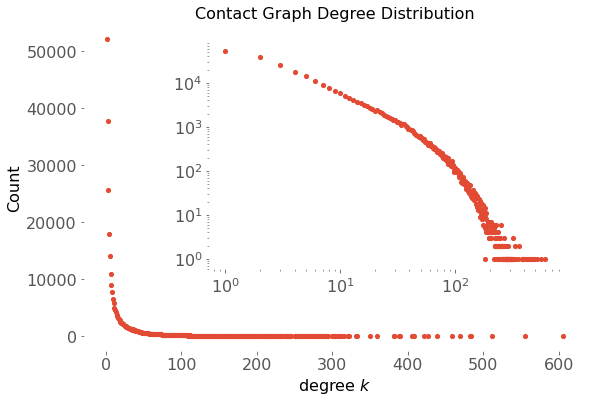

In [30]:
fig, ax = plt.subplots(figsize=(9,6))
ss = 10

## main plot
degree_dist = degree_dist_calculator(G_superposition)
ax.scatter(degree_dist[0], degree_dist[1], alpha=1, linewidth=2, s=ss, marker='o')

## inset
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.25,0.25,0.7,0.7])
ax2.set_axes_locator(ip)
ax2.scatter(degree_dist[0], degree_dist[1], \
            alpha=1, linewidth=2, s=ss, marker='o')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax.set_ylabel("Count")
ax.set_xlabel(r"degree $k$")
ax.set_title('Contact Graph Degree Distribution')

ax.grid(False)
ax2.grid(False)

#plt.savefig("figures/degree_dist_superposition.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

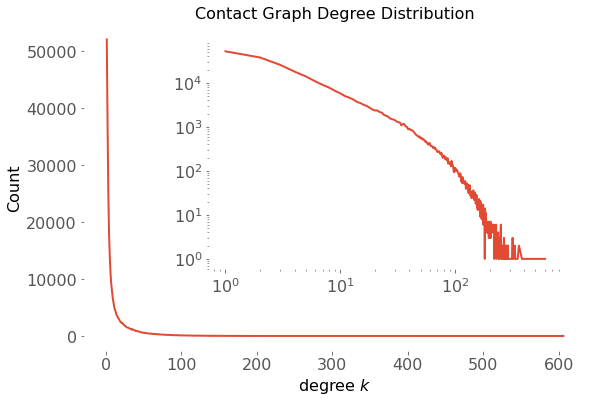

In [31]:
fig, ax = plt.subplots(figsize=(9,6))
ss = 10

## main plot
degree_dist = degree_dist_calculator(G_superposition)
ax.plot(degree_dist[0], degree_dist[1], alpha=1, linewidth=2)

## inset
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.25,0.25,0.7,0.7])
ax2.set_axes_locator(ip)
ax2.plot(degree_dist[0], degree_dist[1], alpha=1, linewidth=2)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax.set_ylabel("Count")
ax.set_xlabel(r"degree $k$")
ax.set_title('Contact Graph Degree Distribution')

ax.grid(False)
ax2.grid(False)

plt.savefig("figures/degree_dist_superposition_with_inset.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

No handles with labels found to put in legend.


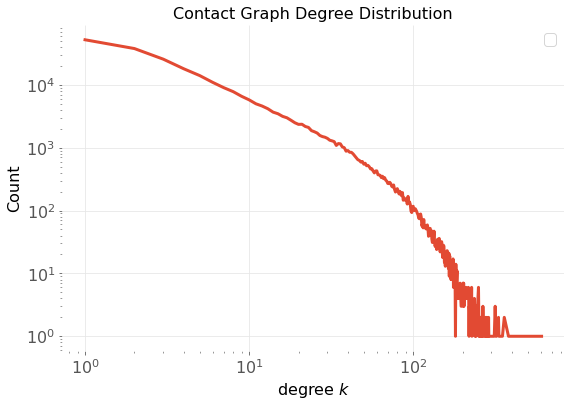

In [32]:
fig, ax = plt.subplots(figsize=(9,6))
lw = 3

## all degrees, log-log sclae
degree_dist = degree_dist_calculator(G_superposition)
ax.plot(degree_dist[0], degree_dist[1], linewidth=lw)#, label='pre social distancing')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[1].set_xlim([0,20])
ax.legend()
ax.set_ylabel("Count")
ax.set_xlabel(r"degree $k$")
ax.set_title('Contact Graph Degree Distribution')

plt.savefig("figures/degree_dist_superposition.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

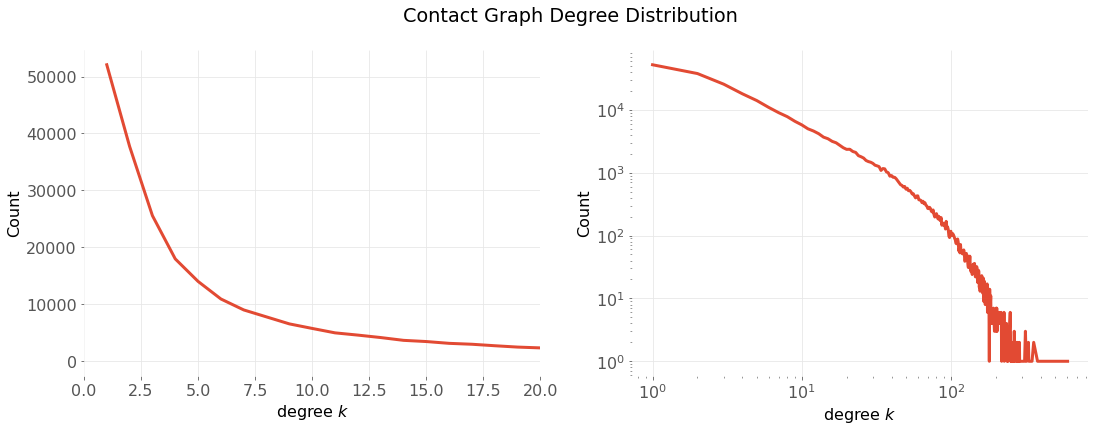

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(2*9,6))
lw = 3

## small degree, linear scale
ax[0].plot(degree_dist[0], degree_dist[1], linewidth=lw)

#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
ax[0].set_xlim([0,20])
ax[0].set_ylabel("Count")
ax[0].set_xlabel(r"degree $k$")
#ax[0].set_title('Contact Graph Degree Distribution')

## all degrees, log-log sclae
ax[1].plot(degree_dist[0], degree_dist[1], linewidth=lw)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].set_xlim([0,20])
ax[1].set_ylabel("Count")
ax[1].set_xlabel(r"degree $k$")
#ax[1].set_title('Contact Graph Degree Distribution')

plt.suptitle('Contact Graph Degree Distribution')

#plt.savefig("figures/degree_dist.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Make a rank-size plot

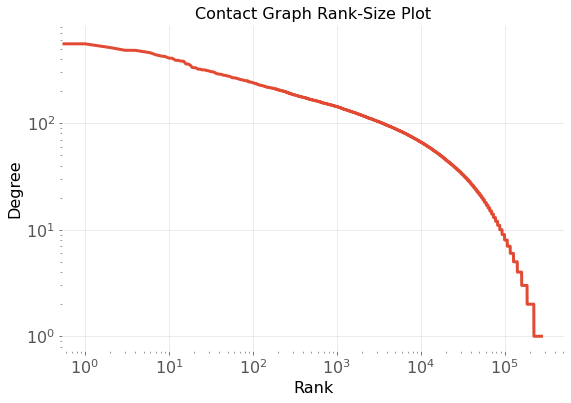

In [34]:
fig, ax = plt.subplots(figsize=(9,6))
lw = 3

ax.loglog(np.arange(G_superposition.number_of_nodes()), -np.sort(-np.asarray(list(nx.degree(G_superposition)))[:,1]), linewidth=lw)

ax.set_ylabel("Degree")
ax.set_xlabel(r"Rank")
ax.set_title('Contact Graph Rank-Size Plot')
plt.show()

Check whether this has a power-law tail

In [35]:
degree_sequence = np.asarray(sorted([d for n, d in G_superposition.degree()], reverse=False))
powerlawfit = powerlaw.Fit(degree_sequence, discrete=True)
print('alpha = ', powerlawfit.power_law.alpha)
print('xmin = ', powerlawfit.power_law.xmin)
R, p = powerlawfit.distribution_compare('power_law', 'lognormal')
print('R = %.4f, p = %.4f' %(R, p))

alpha =  5.505353960910153
xmin =  141.0
R = -0.0076, p = 0.9384


Calculating best minimal value for power law fit
/home/gavin/anaconda3/envs/eon/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/gavin/anaconda3/envs/eon/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


In [36]:
heterogeneity(G_superposition)

{'E(k)': 13.487617321556597,
 'E(k^2)': 678.8208778691239,
 'kappa': 50.32919170861987,
 'kappa/E(k)': 3.7315109488005107}

Degree correlation $k_{nn}(k)$

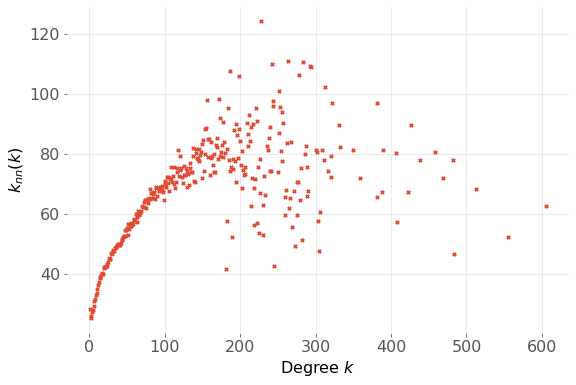

In [37]:
fig, ax1 = plt.subplots(figsize=(9, 6))
#ax2 = plt.axes([0,0,1,1])
#ip = InsetPosition(ax, [0.25,0.25,0.7,0.7])
#ax2.set_axes_locator(ip)
s = 10
marker = 'x'

#ax1.grid(False)
#ax2.grid(False)

knn_dict = nx.k_nearest_neighbors(G_superposition)
#del knn_dict[0] #remove isolates    
k = np.asarray(list(knn_dict.keys()))
knn = np.asarray(list(knn_dict.values()))
ax1.scatter(k, knn, alpha=1, linewidth=2, s=s, marker=marker)
#ax2.scatter(k, knn, alpha=1, linewidth=2, s=s, marker=marker)

ax1.set_xlabel(r'Degree $k$')
ax1.set_ylabel(r'$k_{nn}(k)$')
#ax1.legend()
ax2.set_xscale('log')
#ax2.set_yscale('log')
plt.savefig('figures/assortive_mixing.pdf')
plt.show()

Let's plot all three degree distributions on the same plot

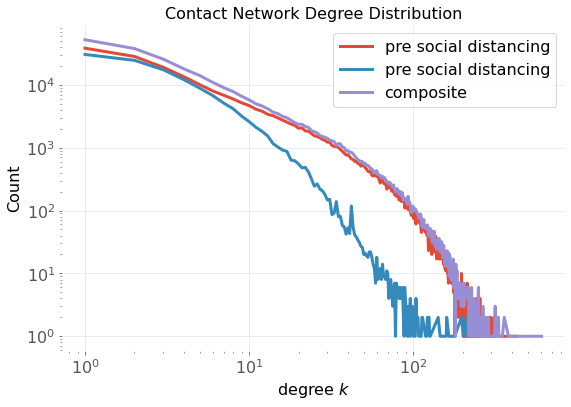

In [38]:
fig, ax = plt.subplots(figsize=(9,6))
lw = 3

## all degrees, log-log sclae
degree_dist_pre = degree_dist_calculator(G_pre)
ax.plot(degree_dist_pre[0], degree_dist_pre[1], linewidth=lw, label='pre social distancing')

degree_dist_post = degree_dist_calculator(G_post)
ax.plot(degree_dist_post[0], degree_dist_post[1], linewidth=lw, label='pre social distancing')

degree_dist_post = degree_dist_calculator(G_superposition)
ax.plot(degree_dist_post[0], degree_dist_post[1], linewidth=lw, label='composite')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[1].set_xlim([0,20])
ax.legend()
ax.set_ylabel("Count")
ax.set_xlabel(r"degree $k$")
ax.set_title('Contact Network Degree Distribution')

plt.savefig("figures/degree_dist_composite.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

## Visualizations of Notional Networks

Here is a simple visualization of ego (star) networks with different degree:

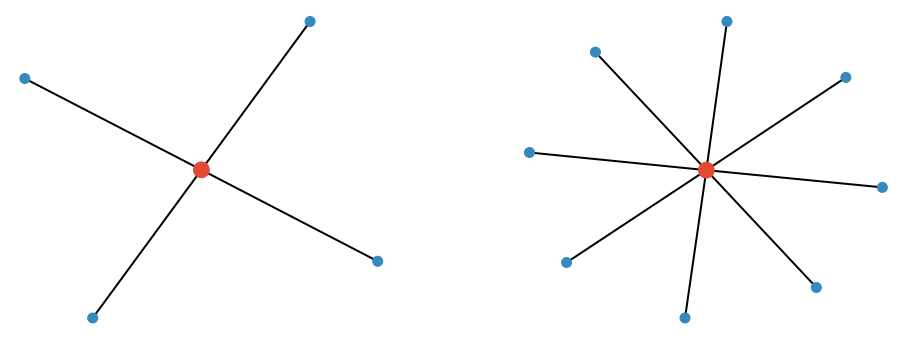

In [39]:
fig, axarr = plt.subplots(1, 2, figsize=(2*8,6))
fig.subplots_adjust(wspace=0.3)

n = 4
lw = 2

G = nx.Graph()
for i in range(1,n+1):
    G.add_edge(0, i)
node_color = [colormap[0]] + n*[colormap[1]]
node_size = [250] + n*[100]
nx.draw_spring(G, node_color=node_color, node_size=node_size, width=lw, ax=axarr[0])

n = 2*n
G = nx.Graph()
for i in range(1,n+1):
    G.add_edge(0, i)
node_color = [colormap[0]] + n*[colormap[1]]
node_size = [250] + n*[100]
nx.draw_spring(G, node_color=node_color, node_size=node_size, width=lw, ax=axarr[1])

#plt.savefig("figures/simple_contact_example.pdf", bbox_inches='tight')
plt.show()

Here's a visualization of a random (BA) graph with uniform and targeted vaccination strategies:

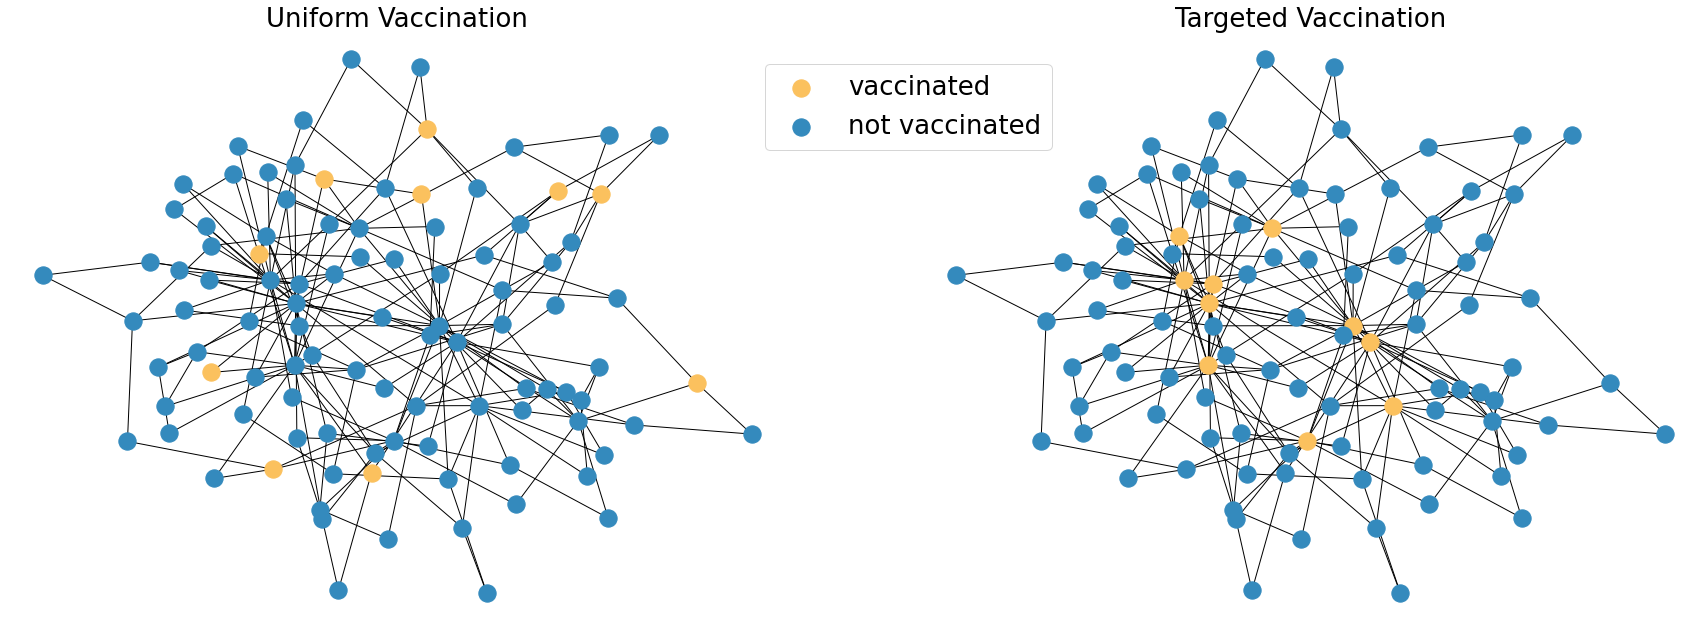

In [40]:
fig, axarr = plt.subplots(1, 2, figsize=(2*12, 1*9))
fig.subplots_adjust(wspace=0.3)

## BA params
N = 100
Nvacc = 10
m = 2
G = nx.barabasi_albert_graph(N, m, seed=123)

## plot params
n = 4
lw = 6
fs = 26

### uniform vacc ####
vacc_nodes = np.random.choice(list(G.nodes()), Nvacc, replace=False)

random.seed(123)
np.random.seed(123)

axarr[0].grid(False)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=vacc_nodes, node_color=colormap[4], ax=axarr[0])
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in range(N) if n not in vacc_nodes], node_color=colormap[1], ax=axarr[0])
nx.draw_networkx_edges(G, pos, ax=axarr[0])    
axarr[0].set_title('Uniform Vaccination', fontsize=fs)

### targeted vacc ####
vacc_nodes = np.asarray(list(dict(G.degree()).values())).argsort()[-Nvacc:][::-1]
        
random.seed(123)
np.random.seed(123)

axarr[1].grid(False)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=vacc_nodes, node_color=colormap[4], ax=axarr[1], label='vaccinated')
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in range(N) if n not in vacc_nodes], node_color=colormap[1], \
                       ax=axarr[1], label='not vaccinated')
nx.draw_networkx_edges(G, pos, ax=axarr[1])    
axarr[1].set_title('Targeted Vaccination', fontsize=fs)
plt.legend(loc=(-0.2, 0.8), fontsize=fs)

plt.tight_layout()
plt.savefig("figures/scale-free.pdf", bbox_inches='tight')
plt.show()